# Programming Assignment 4
## Neural Networks

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Utility Functions

## Metrics

In [174]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    right_prediction = y_true == y_pred
    accuracy = right_prediction.sum() / len(y_true)
    return accuracy

def recall(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,0] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    recall = right_prediction.sum() / len(array)
    return recall

def precision(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,1] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    precision = right_prediction.sum() / len(array)

    return precision

def f1_score(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)

    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return f1_score

def get_mse(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean((y_true - y_pred)**2)

def get_rmse(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.sqrt(get_mse(y_true, y_pred))

def get_mae(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean(np.abs(y_true - y_pred))

def get_mre(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean(np.abs((y_true - y_pred)/y_true))

## MinMaxScaler

In [3]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

## Standardization


In [4]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Cross Validation

In [5]:
def get_cv_folds(data, n_folds=10, shuffle=True, random_state=12894):
    indexes = np.arange(data.shape[0])
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(indexes)

    slices = np.array_split(indexes, n_folds)
    all_elements = np.hstack(slices)   
    
    splits = []
    for i in range(n_folds):
        train_idx = all_elements[~np.isin(all_elements, slices[i])]
        test_idx = slices[i]

        splits.append((train_idx, test_idx))

    return splits

## Train Test Split

In [6]:
def train_test_split(X, y, train_size_perc, random_seed=264852):
    
    y = y.reshape(-1, 1)
    
    N = X.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    X_train = X[train_idx, :]
    y_train = y[train_idx, :]
    X_test = X[test_idx, :]
    y_test = y[test_idx, :]

    return X_train, X_test, y_train, y_test


## Do Cross Validation and Get Metrics

In [7]:
def do_cv_and_get_metrics(classifier, cv_splits, X_train, y_train, X_test, title='Classifier', scaler=None):

    X_train = X_train.copy()
    y_train = y_train.copy()
    X_test = X_test.copy()

    train_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }

    valid_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }
    # Reporting results
    print('#' + f'{title}'.center(60, '-') + '#')

    print('\n---> Validation Folds Metrics')
    print('Fold\tAccuracy\tRecall\t\tPrecision\tF1-Score')
    count_fold = 1
    for train_idx, val_idx in cv_splits:
        # Spliting data
        X_train_cv = X_train[train_idx, :]
        y_train_cv = y_train[train_idx, :]
        X_val_cv = X_train[val_idx, :]
        y_val_cv = y_train[val_idx, :]

        # Scaling if have scaler argument
        if scaler is not None:
            X_train_cv = scaler.fit_transform(X_train_cv)
            X_val_cv = scaler.transform(X_val_cv)

        # Training Model
        classifier.fit(X_train_cv, y_train_cv.ravel())

        # Predictions
        y_train_cv_pred = classifier.predict(X_train_cv)
        y_val_cv_pred = classifier.predict(X_val_cv)

        # Storing metrics
        train_metrics['accuracy'].append(accuracy(y_train_cv, y_train_cv_pred))
        train_metrics['recall'].append(recall(y_train_cv, y_train_cv_pred))
        train_metrics['precision'].append(precision(y_train_cv, y_train_cv_pred))
        train_metrics['f1_score'].append(f1_score(y_train_cv, y_train_cv_pred))

        valid_metrics['accuracy'].append(accuracy(y_val_cv, y_val_cv_pred))
        valid_metrics['recall'].append(recall(y_val_cv, y_val_cv_pred))
        valid_metrics['precision'].append(precision(y_val_cv, y_val_cv_pred))
        valid_metrics['f1_score'].append(f1_score(y_val_cv, y_val_cv_pred))

        print('{0:.0f}\t{1:.4f}  \t{2:.4f}\t\t{3:.4f}   \t{4:.4f}'.format(
                count_fold,
                valid_metrics['accuracy'][-1], 
                valid_metrics['recall'][-1],
                valid_metrics['precision'][-1],
                valid_metrics['f1_score'][-1]
            )
        )
        count_fold+=1


    print('\n--->\tTraining Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['accuracy']), 
        np.std(train_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(train_metrics['recall']), 
        np.std(train_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['precision']), 
        np.std(train_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['f1_score']), 
        np.std(train_metrics['f1_score']))
    )

    print('\n--->\tValidation Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['accuracy']), 
        np.std(valid_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(valid_metrics['recall']), 
        np.std(valid_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['precision']), 
        np.std(valid_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['f1_score']), 
        np.std(valid_metrics['f1_score']))
    )

    print('\n--->\tTest Metrics')

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.ravel())
    y_test_pred = classifier.predict(X_test)

    print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
    print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
    print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
    print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))


# Task 1 - MLP (Regression)

In [8]:
data = np.genfromtxt('../data/concrete.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]


Shape: (1030, 9)


array([[ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1040.  ,  676.  ,
          28.  ,   79.99],
       [ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1055.  ,  676.  ,
          28.  ,   61.89],
       [ 332.5 ,  142.5 ,    0.  ,  228.  ,    0.  ,  932.  ,  594.  ,
         270.  ,   40.27]])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 0.8, random_seed=224852
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 0.75, random_seed=7921
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))
print('X_val:   {} ({}%)'.format(X_val.shape[0], X_val.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 618 (60.0%)
X_test:  206 (20.0%)
X_val:   206 (20.0%)


In [10]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)
X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val)

In [142]:
class Sigmoid():
    @staticmethod
    def get_value(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def get_derivative(x):
        return Sigmoid.get_value(x) - Sigmoid.get_value(x)**2

class TanH:
    @staticmethod
    def get_value(x):
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)

    @staticmethod
    def get_derivative(x):
        return 1 - TanH().get_value(x) ** 2

class ReLU():
    @staticmethod
    def get_value(x):
        return np.maximum(0, x)

    @staticmethod
    def get_derivative(x):
        return np.where(x <= 0, 0, 1)

class Identity():
    @staticmethod
    def get_value(x):
        return np.ones(x.shape) * x

    @staticmethod
    def get_derivative(x):
        return np.ones(x.shape)



## MLP with SGD and Momentum

In [185]:
class MyMLP():

    def __init__(self, n_inputs, n_outputs, learning_rate=0.01, verbose=False):
        self.fitted = False
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_hidden = []
        self.activation_functions = [Identity(), Identity()]
        self.verbose=verbose
        self.learning_rate = learning_rate
        
        
    def add_hidden_layer(self, n_neurons, activation_function):
        self.n_hidden.append(n_neurons)
        self.activation_functions = self.activation_functions[:-1] \
            + [activation_function] \
            + [self.activation_functions[-1]]

    def initialize_weights(self, random_state=None):
        self.weights = []
        self.last_gradient = []

        if random_state is None:
            seed = np.random.RandomState()
        else:
            seed = np.random.RandomState(random_state)

        self.layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
        
        for i in range(len(self.layers)-1):
            # Initialization strategies
            if type(self.activation_functions[i]) == ReLU:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(2/self.layers[i+1])  
                w = np.hstack([np.ones((self.layers[i+1], 1))*0.1, w])
            else:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(1/self.layers[i+1])
                w = np.hstack([np.zeros((self.layers[i+1], 1))*0, w])               

            self.weights.append(w)
            self.last_gradient.append(None)

    #   INITIAL WEIGHTS IN SKLEARN MLPRegressor with random_state=123
    #     self.weights = [np.array([[-0.09777482,  0.27784939,  0.31037599, -0.02696636, -0.08687196,
    #     -0.4490245 ,  0.19007166,  0.31458245, -0.29173239],
    #    [-0.00893062, -0.30244465, -0.10874389, -0.15256887, -0.62270949,
    #     -0.45898053,  0.49417118, -0.25037391,  0.18522821],
    #    [-0.10489181, -0.38629038,  0.67990325, -0.22177978, -0.1441872 ,
    #      0.04462038,  0.31742776, -0.19546036, -0.57685073],
    #    [-0.26550272,  0.07257004,  0.26138872,  0.3239252 ,  0.33657633,
    #      0.04501101,  0.15701095, -0.38429382, -0.0937607 ]]), np.array([[ 0.27156731, -0.1613562 ,  0.86187247,  0.97310584,  0.00402396]])]

        self.momentum_weights = [np.zeros_like(w) for w in self.weights]

    def forward_propagation(self, X):
        input = np.hstack(
            [np.ones((X.shape[0],1)), X]
        )

        self.layer_inputs = []
        self.layer_outputs = []

        self.layer_inputs.append(input)
        self.layer_outputs.append(input)
        
        # Calculating input of next layer
        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]            
            
            self.layer_inputs.append(input)

            # Calculating input of next layer
            output = np.array(input @ w.T)

            # Passing values through the activation function of next layer
            activated_output = activation_function.get_value(output)
            
            if i < len(self.weights)-1:
                activated_output = np.hstack(
                    [np.ones((X.shape[0],1)), activated_output]
                )
            self.layer_outputs.append(activated_output)
            input = activated_output

        return activated_output # Output


    def back_propagation(self, error, learning_rate, momentum_factor=0):
        # calcular os deltas
        output_layer = True
        self.deltas = []
        
        for i in range(len(self.activation_functions)-1, 0, -1):
            act_function = self.activation_functions[i]
            
            if output_layer:
                layer_outputs = self.layer_outputs[i]
                delta_i = error * act_function.get_derivative(layer_outputs)
                self.deltas = [delta_i] + self.deltas
                output_layer=False
            else:
                layer_outputs = self.layer_outputs[i][:, 1:]
                weights = self.weights[i][:, 1:]
                delta_i = act_function.get_derivative(layer_outputs) \
                    * (self.deltas[0] @ weights)
                self.deltas = [delta_i] + self.deltas

        for i in range(len(self.weights)):
            gradient = (self.deltas[i].T @ self.layer_outputs[i]) / len(error)
            update_factor = (learning_rate * gradient) + (momentum_factor * self.momentum_weights[i])
            self.weights[i] -= update_factor
            self.momentum_weights[i] = update_factor
            
    def get_minibatches(self, X, y, batch_size):
        init_index=0
        batches = []

        for final_index in range(batch_size, X.shape[0]+batch_size, batch_size):
            
            X_minibatch = X[init_index:final_index]
            y_minibatch = y[init_index:final_index]

            init_index = final_index
            batches.append((X_minibatch, y_minibatch))
        
        return batches


    def fit(
        self, 
        X, 
        y, 
        valid_set=None, 
        epochs=100, 
        batch_size=32, 
        momentum_factor=0,
        random_state=None,
        random_state_shuffle=None
    ):
        
        self.initialize_weights(random_state)
        
        self.loss_function_curve = []
        self.loss_function_curve_val = []

        train_indexes = np.arange(X.shape[0], dtype=int)

        for i, epochs in enumerate(range(epochs)):
            loss_function = 0
            val_loss_function = 0

            seed = np.random.RandomState(random_state_shuffle)
            seed.shuffle(train_indexes) # inplace
            X = X[train_indexes]
            y = y[train_indexes]
            
            batches = self.get_minibatches(X, y, batch_size)
            
            for input, output in batches:
                y_pred = self.forward_propagation(input)
                if valid_set is not None:
                    X_val, y_val = valid_set[0], valid_set[1]
                    y_val_pred = self.predict(X_val)
                    val_loss_function+=get_mse(y_val, y_val_pred)*input.shape[0]

                error = y_pred - output

                self.back_propagation(
                    error=error, 
                    learning_rate=self.learning_rate,
                    momentum_factor=momentum_factor)

                # y_pred_all = self.predict(X)
                loss_function+=get_mse(output, y_pred)*input.shape[0]
                
            
            self.loss_function_curve.append(loss_function/X.shape[0])
            
            if valid_set is not None:
                self.loss_function_curve_val.append(val_loss_function/X.shape[0])
                if self.verbose:
                    print('Epoch {} -> Loss Function: Train {:.6f} | Valid {:.6f}'.format(
                            i,
                            loss_function/X.shape[0],
                            val_loss_function/X.shape[0]
                        )
                    )
            else:
                if self.verbose:
                    print(f'Epoch {i} | Loss Function: ', loss_function/X.shape[0])

    def plot_learning_curve(self):
        plt.figure(figsize=(14, 8))
        plt.plot(self.loss_function_curve, label='Train')

        if len(self.loss_function_curve_val)>0:
            plt.plot(self.loss_function_curve_val, label='Validation')
        
        plt.title('Learning Curves', fontsize=18)
        plt.legend()

    def predict(self, X):
        input = np.hstack(
            [np.ones((X.shape[0],1)), X]
        )

        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]            
            
            self.layer_inputs.append(input)

            # Calculating input of next layer
            output = np.array(input @ w.T)

            # Passing values through the activation function of next layer
            activated_output = activation_function.get_value(output)
            
            if i < len(self.weights)-1:
                activated_output = np.hstack(
                    [np.ones((X.shape[0],1)), activated_output]
                )
            input = activated_output

        return activated_output


In [189]:
import pandas as pd

def get_regression_metrics(y_true, y_pred, index=''):
    mse = get_mse(y_true, y_pred)
    rmse = get_rmse(y_true, y_pred)
    mae = get_mae(y_true, y_pred)
    mre = get_mre(y_true, y_pred)

    return pd.DataFrame([
        {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MRE': mre
        }
    ], index=[index])


,MSE,RMSE,MAE,MRE
Training,64.005040,8.000315,6.255960,0.217996
Test,82.630570,9.090136,6.628853,0.204674
Validation,77.090453,8.780117,6.417203,0.208284


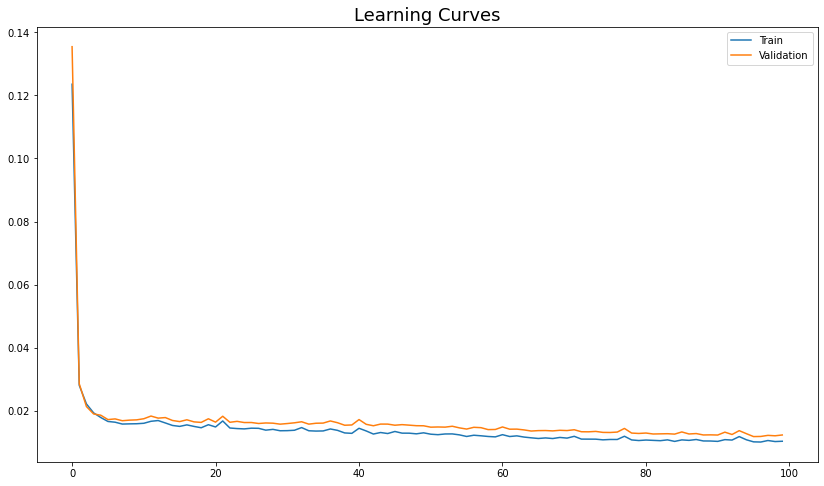

In [190]:
my_mlp = MyMLP(n_inputs=8, n_outputs=1, learning_rate=0.1, verbose=False)
my_mlp.add_hidden_layer(n_neurons=4, activation_function=TanH())
my_mlp.fit(
    X=X_train_scaled, 
    y=y_train_scaled, 
    valid_set=(X_val_scaled, y_val_scaled), 
    epochs=100, 
    batch_size=32,
    momentum_factor=0.9,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

my_mlp.plot_learning_curve()

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])



In [ ]:
from sklearn

In [ ]:
cf_matrix = 

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## MLP with Adam

In [ ]:
class MyMLP_v3():

    def __init__(self, n_inputs, n_outputs, learning_rate=0.01, verbose=False):
        self.fitted = False
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_hidden = []
        self.activation_functions = [Identity(), Identity()]
        self.deltas = []
        self.verbose=verbose
        self.learning_rate = learning_rate
        
        #Adam Parameters
        self.m = 0
        self.v = 0
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon = 1e-08
        
    def add_hidden_layer(self, n_neurons, activation_function):
        self.n_hidden.append(n_neurons)
        self.activation_functions = self.activation_functions[:-1] \
            + [activation_function] \
            + [self.activation_functions[-1]]

    def initialize_weights(self, random_state=None):
        self.weights = []
        self.last_gradient = []

        if random_state is None:
            seed = np.random.RandomState()
        else:
            seed = np.random.RandomState(random_state)

        self.layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
        
        for i in range(len(self.layers)-1):
            # Initialization strategies
            if type(self.activation_functions[i]) == ReLU:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(2/self.layers[i])  
                w = np.hstack([np.ones((self.layers[i+1], 1))*0.1, w])
            else:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(1/self.layers[i])
                w = np.hstack([np.zeros((self.layers[i+1], 1))*0.1, w])               

            self.weights.append(w)
            self.last_gradient.append(None)

    def forward_propagation(self, X):
        input = np.hstack(
            [np.ones((X.shape[0],1)), X]
        )

        self.layer_inputs = []
        self.layer_outputs = []

        self.layer_inputs.append(input)
        self.layer_outputs.append(input)
        
        # Calculating input of next layer
        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]            
            
            self.layer_inputs.append(input)

            # Calculating input of next layer
            output = np.array(input @ w.T)

            # Passing values through the activation function of next layer
            activated_output = activation_function.get_value(output)
            
            if i < len(self.weights)-1:
                activated_output = np.hstack(
                    [np.ones((X.shape[0],1)), activated_output]
                )
            self.layer_outputs.append(activated_output)
            input = activated_output

        return activated_output # Output


    def back_propagation(self, error, learning_rate, momentum_factor=0):
        # calcular os deltas
        output_layer = True
        self.deltas = []
        for i in range(len(self.activation_functions)-1, 0, -1):
            act_function = self.activation_functions[i]
            
            if output_layer:
                layer_inputs = self.layer_outputs[i]
                delta_i = error * act_function.get_derivative(layer_inputs)
                self.deltas = [delta_i] + self.deltas
                output_layer=False
            else:
                layer_inputs = self.layer_outputs[i][:, 1:]
                weights = self.weights[i][:, 1:]

                delta_i = act_function.get_derivative(layer_inputs) \
                    * (self.deltas[0] @ weights)
                self.deltas = [delta_i] + self.deltas

        for i in range(len(self.weights)):

            gradient = self.deltas[i].T @ self.layer_outputs[i]

            m = self.beta_1 * self.m
            


            if self.last_gradient[i] is None:
                # print('Entrou NONE'
                self.weights[i] = self.weights[i] - learning_rate * gradient
            else:
                # print('Entrou LAST')
                self.weights[i] = self.weights[i] - ((learning_rate * gradient) \
                    + (momentum_factor * self.last_gradient[i]))
            
            
            
            
            self.last_gradient[i] = learning_rate * gradient



    def get_minibatches(self, X, y, batch_size):
        init_index=0
        batches = []

        for final_index in range(batch_size, X.shape[0]+batch_size, batch_size):
            
            X_minibatch = X[init_index:final_index]
            y_minibatch = y[init_index:final_index]

            if X_minibatch.shape[0] < batch_size:
                n_missing_rows = batch_size - X_minibatch.shape[0]
                X_minibatch = np.vstack([X_minibatch, X[0:n_missing_rows]])
                y_minibatch = np.vstack([y_minibatch, y[0:n_missing_rows]])

            init_index = final_index
            batches.append((X_minibatch, y_minibatch))
        
        return batches


    def fit(
        self, 
        X, 
        y, 
        valid_set=None, 
        epochs=100, 
        batch_size=32, 
        momentum_factor=0,
        random_state=None,
        random_state_shuffle=None
    ):
        
        self.initialize_weights(random_state)
        
        self.loss_function_curve = []
        self.loss_function_curve_val = []

        train_indexes = np.arange(0, X.shape[0], 1)

        for i, epochs in enumerate(range(epochs)):
            loss_function = 0
            val_loss_function = 0
            count = 0
            
            seed = np.random.RandomState(random_state_shuffle)
            seed.shuffle(train_indexes)
            X_shuffle = X[train_indexes]
            y_shuffle = y[train_indexes]
            
            batches = self.get_minibatches(X_shuffle, y_shuffle, batch_size)
            
            for input, output in batches:
                y_pred = self.forward_propagation(input)
                
                if valid_set is not None:
                    X_val, y_val = valid_set[0], valid_set[1]
                    y_val_pred = self.predict(X_val)
                    val_loss_function+=get_mse(y_val, y_val_pred)


                error = y_pred - output
                self.back_propagation(
                    error=error, 
                    learning_rate=self.learning_rate,
                    momentum_factor=momentum_factor)
                loss_function+=get_mse(output, y_pred)
                count+=1
                
            self.loss_function_curve.append(loss_function/count)
            
            
            if valid_set is not None:
                self.loss_function_curve_val.append(val_loss_function/count)
                if self.verbose:
                    print('Epoch {} -> Loss Function: Train {:.6f} | Valid {:.6f}'.format(
                            i,
                            loss_function/count,
                            val_loss_function/count
                        )
                    )
            else:
                if self.verbose:
                    print(f'Epoch {i} | Loss Function: ', loss_function/count)

    def plot_learning_curve(self):
        plt.figure(figsize=(14, 8))
        plt.plot(self.loss_function_curve, label='Train')

        if len(self.loss_function_curve_val)>0:
            plt.plot(self.loss_function_curve_val, label='Validation')
        
        plt.title('Learning Curves', fontsize=18)
        plt.legend()

    def predict(self, X):
        input = np.hstack(
            [np.ones((X.shape[0],1)), X]
        )

        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]            
            
            self.layer_inputs.append(input)

            # Calculating input of next layer
            output = np.array(input @ w.T)

            # Passing values through the activation function of next layer
            activated_output = activation_function.get_value(output)
            
            if i < len(self.weights)-1:
                activated_output = np.hstack(
                    [np.ones((X.shape[0],1)), activated_output]
                )
            input = activated_output

        return activated_output


## Teste Keras

In [160]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
import keras
import tensorflow as tf

7/7 [==============================] - 0s 835us/step

---- RESULTS ----
MSE Train:	 0.03156169755130557
MSE Test:	 0.033101312548515054
MSE Validation:	 0.028817962230341252


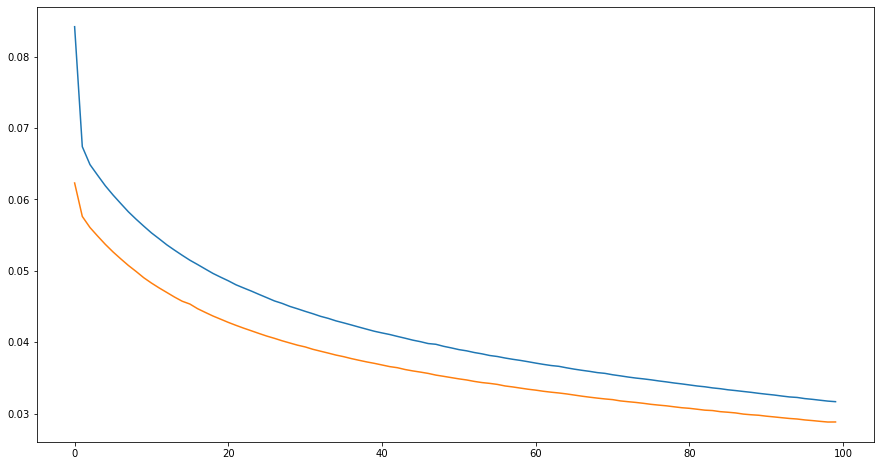

In [166]:
model = Sequential()

model.add(tf.keras.Input(shape=(8,)))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0), metrics=['mse'])

history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=100, batch_size=32, verbose=False)

plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_val_pred = model.predict(X_val_scaled)

mse_train = get_mse(y_train_scaled, y_train_pred)
mse_test = get_mse(y_test_scaled, y_test_pred)
mse_val = get_mse(y_val_scaled, y_val_pred)

print('\n---- RESULTS ----')
print('MSE Train:\t', mse_train)
print('MSE Test:\t', mse_test)
print('MSE Validation:\t', mse_val)


## Sklearn MLP

In [15]:
from sklearn.neural_network import MLPRegressor


---- RESULTS ----
MSE Train:	 0.015268474180527153
MSE Test:	 0.018379719854785214
MSE Validation:	 0.016310578914193713


c:\Users\edyalenquer\.conda\envs\ml-project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:704: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


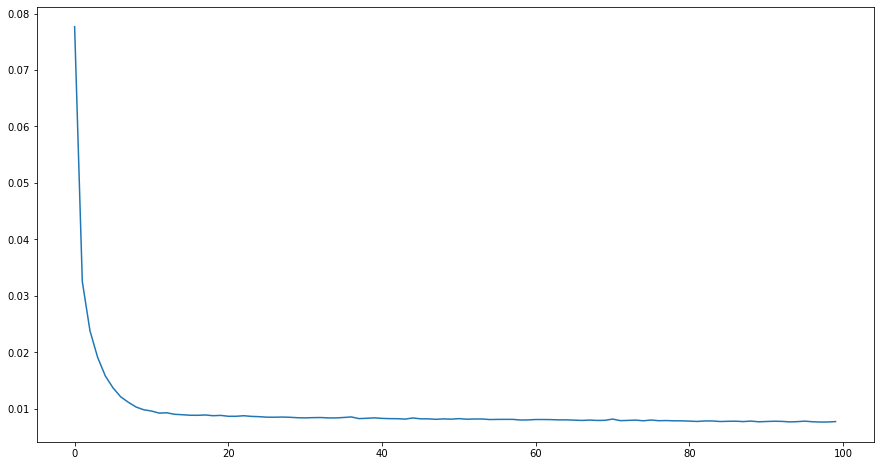

In [170]:
sk_mlp = MLPRegressor(
    hidden_layer_sizes=(4), 
    activation='tanh', 
    solver='sgd',
    batch_size=32, 
    learning_rate="constant",
    shuffle=True,
    power_t=0,
    momentum=0.5,
    tol=0.000000001, 
    learning_rate_init=0.1, 
    validation_fraction=0,
    max_iter=100,
    n_iter_no_change=9999999,
    alpha=0,
    nesterovs_momentum=False,
    verbose=False,
    random_state=123
)
sk_mlp.fit(X_train_scaled, y_train_scaled.ravel())

plt.figure(figsize=(15,8))
plt.plot(sk_mlp.loss_curve_)

y_train_pred = sk_mlp.predict(X_train_scaled).reshape(-1, 1)
y_test_pred = sk_mlp.predict(X_test_scaled).reshape(-1, 1)
y_val_pred = sk_mlp.predict(X_val_scaled).reshape(-1, 1)

mse_train_sk = get_mse(y_train_scaled, y_train_pred)
mse_test_sk = get_mse(y_test_scaled, y_test_pred)
mse_val_sk = get_mse(y_val_scaled, y_val_pred)

print('\n---- RESULTS ----')
print('MSE Train:\t', mse_train_sk)
print('MSE Test:\t', mse_test_sk)
print('MSE Validation:\t', mse_val_sk)


-------- MLP SGD - My Result --------
MSE Train:	 0.017722635669701812
MSE Test:	 0.021496061841218706
MSE Validation:	 0.01827291756463349


----- MLP SGD - Sklearn Results -----
MSE Train:	 0.01296755143752469
MSE Test:	 0.01574801596463635
MSE Validation:	 0.013995132075320894


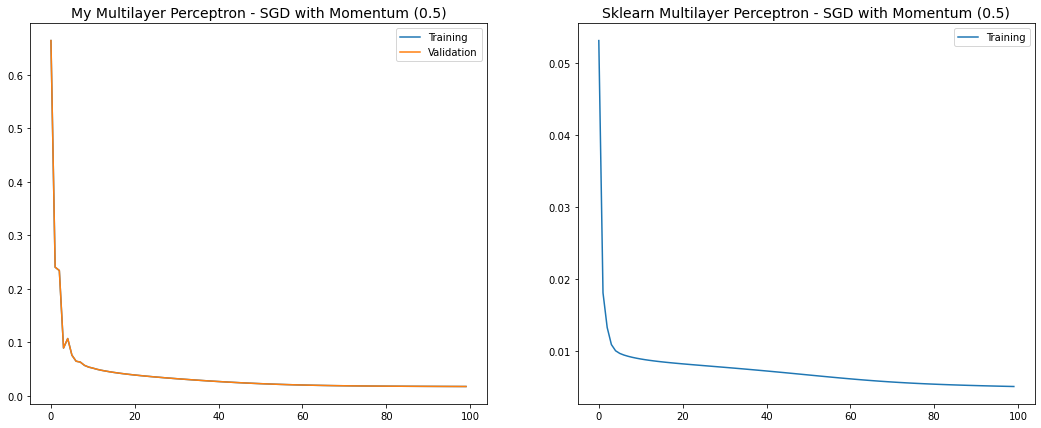

In [101]:
print(' MLP SGD - My Result '.center(37, '-'))
print('MSE Train:\t', mse_train)
print('MSE Test:\t', mse_test)
print('MSE Validation:\t', mse_val)

print('\n')
print(' MLP SGD - Sklearn Results '.center(37, '-'))
print('MSE Train:\t', mse_train_sk)
print('MSE Test:\t', mse_test_sk)
print('MSE Validation:\t', mse_val_sk)

fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ax[0].plot(my_mlp.loss_function_curve, label='Training')
ax[0].plot(my_mlp.loss_function_curve, label='Validation')
ax[0].set_title('My Multilayer Perceptron - SGD with Momentum (0.5)', fontsize=14)

ax[1].plot(sk_mlp.loss_curve_, label='Training')
ax[1].set_title('Sklearn Multilayer Perceptron - SGD with Momentum (0.5)', fontsize=14)

ax[0].legend()
ax[1].legend()
